# 💰️Bag-of-Words Model for Sentiment Classification

## Introduction

Welcome to your first assignment! In this assignment, you will be implementing your very first NLP model (woohoo!) - a bag-of-words (BOW) model for sentiment classification. You will be using a very useful NLP libary (spaCy), and a popular machine learning library (scikit-learn, or sklearn) to help you with preprocessing the data and building the BOW model. In later lectures and assignments, you will learn to implement many of these NLP and machine learning functions yourself, but in "the real world" it is often more practical to use existing libraries, like those provided by spaCy and sklearn, than to implement these algorithms from scratch. So here we want you to learn how to use these libraries in a practical setting, and we'll learn later more about how they work "under the hood".

The main learning objectives for this assignment are:

1. Use sklearn to implement a standard ML workflow (featurization, designing train-test splits, training a model, and evaluating the model).
2. Use spaCy for standard NLP preprocessing steps (tokenization, lemmatization, tagging).
3. Understand and implement common featurization approaches for text classifiers (ngrams, weighting schemas, tagging).

The basic workflow for an NLP model contains the following steps:

1. Load and explore the data
2. Preprocess the data
3. Extract features
4. Train the model
5. Evaluate the model
6. Analyze model behavior

You will implement this full workflow in Part 1. In Part 2, you will experiment with improvements to step 2 (preprocessing). In Part 3, you will experiment with improvements to step 3 (featurization).

## Before you start

In this class, we will be using Google Colab notebooks for assignments instead of regular Python files. Colab provides more efficient Google GPUs and is easier for setting up. Colab is also a very powerful platform and it functions very similarly to a Jupyter notebook. We'll provide a few tips on how to use Colab below; make sure you read them carefully!

☝ **Quick Colab Tips:**

- Make sure you **create a copy** of the Colab file before you start coding!! (File > Save a copy in Drive). If you don't do this, you will lose everything when you close the page and we DON'T want that to happen to you!
- To run a cell, press the play button in its top left corner. Make sure you run all previous cells before running the next one, so that every function and variable you need is defined.
- If you don't want to run each cell individually, you can click Runtime and you will find "Run Before", "Run After", or "Run All".
- When you reload the page, the runtime restarts and all variables in the environment are cleared. This means that you will need to re-run cells.
- If you make changes to a definition in an earlier cell, remember to run the cell to actually update the definition. Then remember to re-run all the cells after using that definition, or else they will still be using the previous value.
- For more tips on getting started, please take a look at this [video](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow).

## Installation and Imports
☝ **Quick Tip:** You can add "**!**" in front a Linux command and it can run on Colab!

The following code will ask to access your Google Drive; you will be downloading the dataset used in this assignment to your Google Drive, and uploading it via this access.

In [17]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install scikit-learn

import os
import spacy

import numpy as np
import pandas as pd
import pickle
from typing import TypeAlias

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive


# Part 1: BOW Workflow


### Step 1: Load the raw data and explore it


In this assignment, we'll be using a dataset of tweets pulled from Twitter. Download the dataset [from Google Drive here](https://drive.google.com/file/d/1Rx-HWAWFVD5oJjIQL5u0fxvbPrBnLwmJ/view?usp=sharing). Add it to your own Google Drive and change the `FOLDER` variable below to reflect its location. (Generally it should start with "/content\/drive\/My Drive". You can click on the file icon on the bar on the left to see how your Drive has been mounted. Click the three dots to the right of the folder and "Copy path" to get the path to your folder.)

In the dataset, the tweets are classified according to three categories of sentiment: positive, negative and neutral. We will use the tweets in the `text` column and the sentiments in the `sentiment` column of the CSV file. Feel free to read the Pandas documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) if you are unfamiliar with Pandas Dataframes.


In [18]:
FOLDER = "/content/drive/MyDrive/2024-2025_Sophmore/Fall/CS1460/data"
FILEPATH = f"{FOLDER}/Tweets_5K.csv"

In [19]:
def load_data(filepath: str) -> tuple[list[str], list[int]]:
    """
    Loads Twitter data into two lists.

    Returns
    -------
    raw_tweets : list[str]
        A list of all Tweets in the dataset
    labels : list[int]
        A list of the sentiments corresponding to each raw tweet encoded as integers,
        -1 meaning negative, 0 meaning neutral, and 1 meaning positive
    """
    # TODO: Load data from the CSV file using filepath
    # Remember to map positive tweets to 1, neutral tweets to 0, and negative tweets to -1.
    dataset = pd.read_csv(filepath)
    raw_tweets = dataset["text"].astype(str).tolist()
    labels=[]
    for label in dataset["sentiment"].astype(str).tolist():
      if label == "neutral":
        labels.append(0)
      elif label == "negative":
        labels.append(-1)
      else:
        labels.append(1)
    return (raw_tweets, labels)

Before you start to preprocess data, you should always take a look at the dataset and get a sense of the data you're handling.


In [20]:
raw_tweets, labels = load_data(FILEPATH)
for p, label in zip(raw_tweets[:10], labels[:10]):
    print(f"{label}:\t{p}\n")

0:	 I`d have responded, if I were going

-1:	 Sooo SAD I will miss you here in San Diego!!!

-1:	my boss is bullying me...

-1:	 what interview! leave me alone

-1:	 Sons of ****, why couldn`t they put them on the releases we already bought

0:	http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth

1:	2am feedings for the baby are fun when he is all smiles and coos

0:	Soooo high

0:	 Both of you

1:	 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)



We can use matplotlib to see the ratio between the number of positive, negative and neutral tweets.


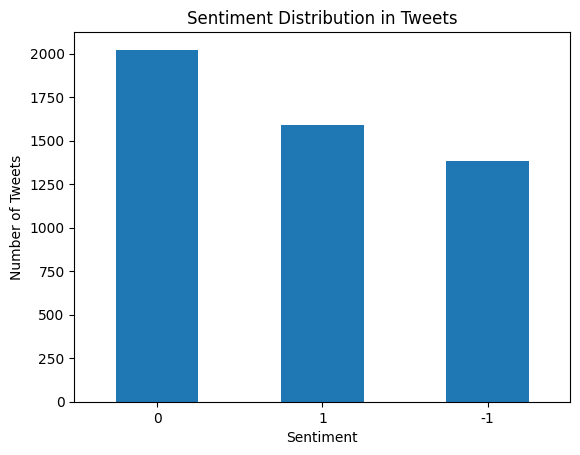

In [21]:
import matplotlib.pyplot as plt

plt.figure()
pd.Series(labels).value_counts().plot.bar(title="Sentiment Distribution in Tweets")
plt.xticks(rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

### Step 2: Preprocess the data


For now, all you need to do for preprocessing is split the tweets by whitespace.


In [22]:
def preprocess(raw_X: list[str]) -> list[list[str]]:
    """
    Performs splitting on whitespace on all raw strings in a list.

    Parameters
    ----------
    raw_X : list[str]
        A list of raw strings (tweets)

    Returns
    -------
    list[list[str]]
        A list of preprocessed tweets (which are now lists of words)
    """
    preprocessed_tweets = []
    for string in raw_X:
      preprocessed_tweets.append(string.split())
    # TODO Basic tokenization just based on whitespace, with no other preprocessing
    return preprocessed_tweets

### Steps 3 & 4: Define featurization + train and test functions


In [23]:
from scipy.sparse import csr_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

class BOW_Classifier:
    """
    Attributes
    ----------
    clf : LogisticRegression
        A logistic regression classifier
    dv : DictVectorizer
        A dictionary vectorizer for turning dictionaries into matrices
    """

    def __init__(self):
        # TODO: Initialize class attributes
        # HINT: Use max_iter=150 when initializing your LogisticRegression classifier to get expected performance!
        # You are allowed to ignore the DictVectorizer dv attribute, as well as add more to the init method, if you wish
        self.clf = LogisticRegression(max_iter=150)
        self.dv = DictVectorizer()

    def featurize(self, preproc_X: np.ndarray[list[str]], is_test: bool = False) -> csr_matrix:
        """
        Turns a list of preprocessed tweets into a binary bag-of-words matrix.

        Parameters
        ----------
        preproc_X : np.ndarray[list[str]]
            A list of preprocessed tweets
        is_test: bool, default=False
            Whether featurization should be done using features learned during training (is_test=True)
            or whether it should be done with features extracted from scratch using preproc_X (is_test=False)

        Returns
        -------
        csr_matrix
            A matrix with rows corresponding to tweets and columns corresponding to words
        """
        # TODO: Implement a binary bag-of-words for unigrams
        vocab = []
        for string in preproc_X:
          tweet_dict = {}
          for word in string:
            tweet_dict[word] = 1
          vocab.append(tweet_dict)
        if is_test:
          matrix = self.dv.transform(vocab)
        else:
          matrix = self.dv.fit_transform(vocab)
        return matrix

    def train(self, X_train: np.ndarray[list[str]], y_train: np.ndarray[int]):
        """
        Trains the BOW classifier on the given training data.

        Parameters
        ----------
        X_train : np.ndarray[list[str]]
            Preprocessed tweets for training
        y_train : np.ndarray[int]
            Sentiments corresponding to the tweets in X_train
        """
        # TODO
        BoW_matrix = self.featurize(X_train, is_test = False)
        self.clf.fit(BoW_matrix, y_train)

    def test(self, X_test: np.ndarray[list[str]]) -> np.ndarray[int]:
        """
        Classifies the given test data and returns predicted sentiments.

        Parameters
        ----------
        X_test : np.ndarray[list[str]]
            Preprocessed tweets for testing

        Returns
        -------
        y_pred : np.ndarray[int]
            Predicted sentiments for the tweets in X_test
        """
        # TODO
        BoW_test_matrix = self.featurize(X_test, is_test = True)
        return self.clf.predict(BoW_test_matrix)


### Step 5: Evaluate the model


To evaluate the model, we need to simulate the "real world" setting in which we have trained on our model on the data we have, but now we are using it to assign labels to data we have never seen before. We will do this using stratified k-fold cross validation.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called `k` that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. This procedure is called "stratified" when the data is divided so that examples from each class (in this case, the classes are the three sentiments) are distributed evenly among all folds.


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def run_kfold_crossval(
    model: BOW_Classifier, X: list[list[str]], y: list[int], k: int = 5
) -> list[float]:
    """
    Executes k-fold cross-validation.

    Parameters
    ----------
    model : BOW_Classifier
        A BOW model that has train and test methods
    X : list[list[str]]
        Preprocessed tweets for training and testing
    y : list[int]
        Sentiments corresponding to the tweets in X
    k : int, default=5
        The number of folds to use for cross-validation

    Returns
    -------
    list[float]
        A list of accuracy values from testing with each fold
    """
    # TODO: Implement stratified k-fold cross-validation with a BOW_Classifier model
    # HINT: Consult the documentation for the imports at the top of this cell
    # HINT 2: If you have trouble casting a ragged nested list to a numpy array, try passing dtype=list
    accuracy_values = [0] * k
    X, y = np.array(X, dtype=list), np.array(y, dtype=int)
    skf = StratifiedKFold(n_splits = k)
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
      training_tweets, training_sentiments = X[train_index], y[train_index]
      model.train(training_tweets, training_sentiments)
      pred = model.test(X[test_index])
      accuracy = accuracy_score(y[test_index], pred)
      accuracy_values[i] = accuracy
    return accuracy_values


### Step 6: Plotting model performance


This function will plot how well our model is doing. :)


In [25]:
def plot_perfs(perfs: list[list[float]], names: list[str], k: int = 5):
    """
    Plots performances of models in a bar chart.

    Parameters
    ----------
    perfs : list[list[float]]
        A list of accuracy results for each model
    names : list[str]
        The names of each of the models (in the same order as perfs)
    k : int, default=5
        The value of k used for cross-validation when producing the performances
    """
    means = []
    stds = []
    for i, perf in enumerate(perfs):
        mean = np.mean(perf)
        means.append(mean)
        stds.append(np.std(perf))
        print("%s:\t%.03f" % (names[i], mean))
    plt.bar(np.arange(len(means)), means, yerr=stds)
    plt.xticks(np.arange(len(names)), names)
    plt.ylabel(f"Accuracy with {k} Folds")
    plt.ylim(0, 1)
    plt.show()

### Step 7: Run the full workflow!


MFC Baseline:	0.405
Basic BOW:	0.598


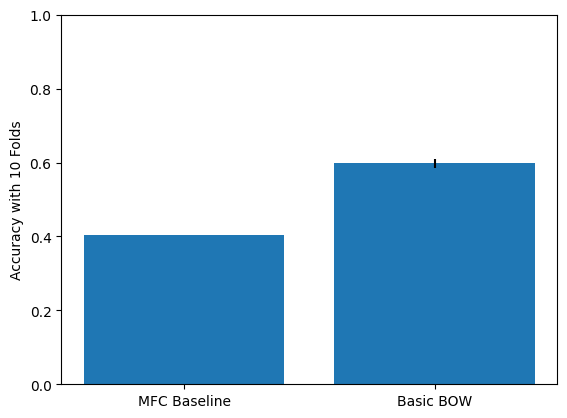

In [26]:
from collections import Counter

K_FOLD = 10
raw_tweets, y = load_data(FILEPATH)

X_preproc = preprocess(raw_tweets)
bow_model = BOW_Classifier()
basic_bow_accs = run_kfold_crossval(bow_model, X_preproc, y, k=K_FOLD)

# here, we are going generate the "most frequent class" baseline based on the training data
counts = Counter(y).values()
mfc_baseline = [max(counts) / sum(counts)] * K_FOLD

# plot the results!
plot_perfs([mfc_baseline, basic_bow_accs], ["MFC Baseline", "Basic BOW"], k=K_FOLD)

# Part 2: Improved Preprocessing


In this section, we are going to improve the preprocessing step, but otherwise keep the above workflow the same.


### Loading Data with Spacy

The cell block below will load the dataset into spacy_processed_docs, a list of spaCy docs (spacy.tokens.doc.Doc) that will be passed to the preprocess_part2 function below. Loading and parsing all the data using spaCy may take a while, so we've set it up to save the processed docs to a pickle file (saved in the same folder in your Google Drive where you put the dataset) that will be reloaded the next time(s) you run the cell.

When debugging, you may find that having too many tweets will make debugging difficult. Feel free to change `NUM_TWEETS` to a smaller number while debugging, but make sure to change it back once finished.


In [27]:
spacy_doc: TypeAlias = spacy.tokens.doc.Doc

NUM_TWEETS = 5000  # INFO: Feel free to change this to load in fewer tweets when debugging, but otherwise keep it at 5000
nlp = spacy.load("en_core_web_sm")
CACHE_PATH = f"{FOLDER}/parsed_{NUM_TWEETS}_tweets.pickle"

if os.path.exists(CACHE_PATH):
    print(f"Loading parsed tweets from cache at {CACHE_PATH}")
    parsed_tweets = pickle.load(open(CACHE_PATH, "rb"))
else:
    # parse all the tweets with spacy
    parsed_tweets = []
    for i, r in enumerate(raw_tweets):
        if i == NUM_TWEETS:
            break
        parsed_tweets.append(nlp(r))
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1} out of {len(raw_tweets)}", end="\r")
    print("Processing complete")
    if CACHE_PATH is not None:
        pickle.dump(parsed_tweets, open(CACHE_PATH, "wb"))

print(f"{len(parsed_tweets)} parsed tweets loaded.")

Loading parsed tweets from cache at /content/drive/MyDrive/2024-2025_Sophmore/Fall/CS1460/data/parsed_5000_tweets.pickle
5000 parsed tweets loaded.


### Re-implement pre-processing

Please implement `preprocessing_part2` to do the following things (not necessarily in this order):

- lowercasing
- lemmatization
- remove stop words
- remove punctuation and extra white space
- use only top 1000 most frequent words, and replace the rest with "\<OOV\>"
- replace numbers with "\<NUM\>"

**Think about how each step affects the next one in the pipeline.** Specifically, one of these steps makes most sense to do last, so make sure your code reflects that.

Your final feature matrix should have 1001 columns (1000 most frequent words and one OOV token).

Use spaCy to do these things. You shouldn't need to import any additional libraries (but hint: we've imported the Counter library in a previous cell). You can explore the spaCy documentation [here](https://spacy.io/api/) and [here](http://spacy.pythonhumanities.com/01_02_linguistic_annotations.html#token-attributes).


In [28]:
def preprocess_part2(parsed_tweets: list[spacy_doc], K: int = 1000) -> list[list[str]]:
    """
    Preprocesses the spaCy-parsed tweets.

    Parameters
    ----------
    parsed_tweets : list[spacy_doc]
        A list of tweets parsed by spaCy
    K : number of most frequent words to include (default: 1000)

    Returns
    -------
        A list of preprocessed tweets formatted as lists of tokens (lists of strings)
    """
    # TODO: preprocessing steps outlined above
    preprocessed_tweets=[]
    token_counts = Counter()
    for tweet in parsed_tweets:
      preprocessed_tweet=[]
      for token in tweet:
        if token.is_space or token.is_stop or token.is_punct:
          continue
        if token.like_num:
          proc_word = "<NUM>"
        else:
          proc_word = token.lemma_.lower()
        preprocessed_tweet.append(proc_word)
        token_counts[proc_word] += 1
      preprocessed_tweets.append(preprocessed_tweet)

    topK = token_counts.most_common(K)
    topWords = set()
    for word in topK:
      topWords.add(word[0])
    for tweet in preprocessed_tweets:
      for i in range(len(tweet)):
        if tweet[i] not in topWords:
          tweet[i] = "<OOV>"
    return preprocessed_tweets

Now let's re-run the workflow and observe the difference in performance!


MFC Baseline:	0.405
Basic BOW:	0.598
BOW+preproc:	0.634


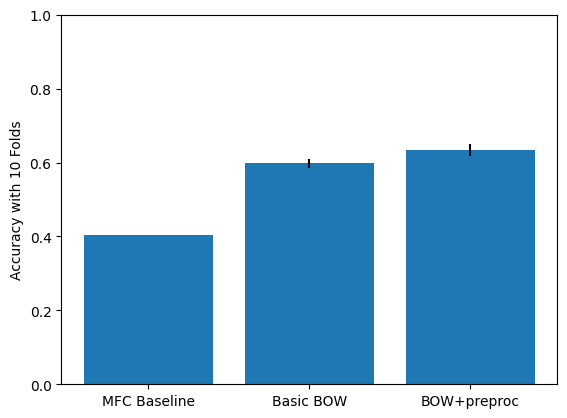

In [29]:
X_preproc = preprocess_part2(parsed_tweets)
bow_model = BOW_Classifier()
better_preproc_accs = run_kfold_crossval(bow_model, X_preproc, y, k=K_FOLD)

plot_perfs(
    [mfc_baseline, basic_bow_accs, better_preproc_accs],
    ["MFC Baseline", "Basic BOW", "BOW+preproc"],
    k=K_FOLD,
)

# Part 3: Improved Featurization


In this section, we will expand the featurize function to include more advanced and sophisticated features. You will now add n-grams with n values from 1 to 5 as features to (partially) preserve the order of the sentence.

**Note:** You are not allowed to use a CountVectorizer to produce n-grams.

In [30]:
class Better_BOW(BOW_Classifier):
    """
    A subclass of BOW_Classifier with a more complex featurization function.

    All attribute and method names match those of BOW_Classifier.
    """

    def featurize(self, preproc_X: np.ndarray[list[str]], is_test: bool = False) -> csr_matrix:
        """
        Turns a list of preprocessed tweets into a bag-of-words matrix using n-grams up to 5-grams.

        Parameters
        ----------
        preproc_X : list[list[str]]
            A list of preprocessed tweets
        is_test: bool, default=False
            Whether featurization should be done using features learned during training (is_test=True)
            or whether it should be done with features extracted from scratch using preproc_X (is_test=False)

        Returns
        -------
        csr_matrix
            A matrix with rows corresponding to tweets and columns corresponding to n-grams
        """
        # TODO: Implement a binary BOW for 1-, 2-, 3-, 4-, and 5-grams

        vocab=[]
        for tweet in preproc_X:
          mp={}
          for n in range(1,6):
            for i in range(len(tweet)-n + 1):
              mp[tuple(tweet[i:i+n])] = 1
          vocab.append(mp)
        if is_test:
          matrix = self.dv.transform(vocab)
        else:
          matrix = self.dv.fit_transform(vocab)
        return csr_matrix(matrix)



MFC Baseline:	0.405
Basic BOW:	0.598
BOW+preproc:	0.634
Better Features:	0.638


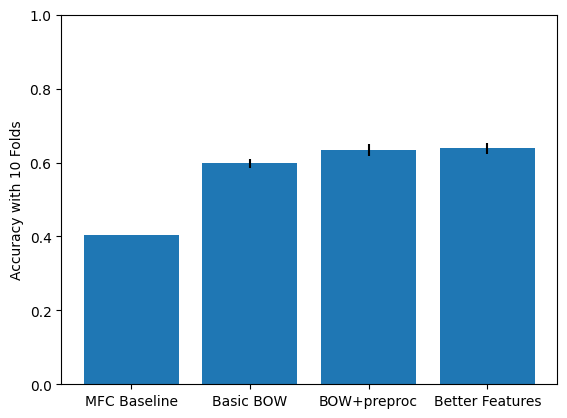

In [31]:
X_preproc = preprocess_part2(parsed_tweets)
better_bow = Better_BOW()
better_feature_accs = run_kfold_crossval(better_bow, X_preproc, y, k=K_FOLD)

plot_perfs(
    [mfc_baseline, basic_bow_accs, better_preproc_accs, better_feature_accs],
    ["MFC Baseline", "Basic BOW", "BOW+preproc", "Better Features"],
    k=K_FOLD,
)

# ❗ Conceptual Questions
### Type your answer below each question (part) in the Colab cell below. 👇 [Don't miss this section!]

#### 1. **What do the dimensions of the feature matrix correspond to?**
In Part 1, the dimensions of the feature matrix are such that each row corresponds to a tweet, and each column corresponds to every word in the 'text' column of the Twitter dataset. In Part 3, each row corresponds to a tweet, and each column corresponds to all n-grams (1 to 5) that can be formed with the words in all the tweets.
#### 2. Find an example of a word that appears in the test set but never appears in the training set. What word did you find, and what is the tweet in which it occurred? **Include the code used to answer this question in the cell below.** Use any training and testing set that could be generated using K-Fold where `k=5`.
A word that appears in the test set but never in the training set is "kidnap". The tweet in which it occured was "Wishing I could kidnap  from work".
#### 3. What happens to that new word when the tweet is featurized at test time? i.e., describe what feature representation of the tweet that contains the unknown word would look like? **(Do not simply copy or write down the literal feature representation)**
If we are performing the preprocessing step from part 2, the feature representation of the tweet that contains the unknown word would be represented with an "<OOV>" because it is not within the top K elements.
#### 4. For each of the below preprocessing steps, indicate whether it is likely to result in more features or fewer, **all else being equal**. You can assume you are working with a very large corpus in which all words occur at least once. For each step, provide a one-sentence justification.
**a. Lowercasing**
Fewer features. This is because the same words that would otherwise be considered unique without lowercasing, would be considered the same word once we perform lowercasing (i.e. "Fall" and "FALL"). \\
    **b. Vocabulary Thresholding/Replacing Rare Words** \\
Fewer features because the number of features will only be the top k elements. \\
    **c. Spelling out contractions (i.e., "I'm" -> "I am")** \\
Less features because the spelled out word and contraction will be considered one feature. \\
    **d. Spelling out abbreviations (i.e., "RI" -> "Rhode Island")** \\
Less features. Under the assumption all words occur at least once, both the abbreviated and full word will be consolidated into one feature. \\
    **e. Part of Speech Tagging** \\
More features because this adds an additional characteristic that distinguishes words that would otherwise be considered the same feature.  \\
    **f. Preserving typeface (i.e., indicating whether a word was italicized or bolded in the original text).**  \\
More features because this differentiates a word into multiple representations which will end up adding features. For example, "**fall**","*fall*", and "fall" will be different features.
5. **A bag-of-words model does not take into account word order or number of words. Provide a context where a BOW model might fail for this reason.**
A BOW model might fail when a sentence uses the same word multiple times but in different meanings. An example of this is the sentence "Tom runs the company, and everyday, he runs a mile." Since the bag of words does not take into account the number of words, it loses the context in which the words are used. Another context is when word choice is essential for understanding the sentence. For example, "John chased Bob" and "Bob chased John" will be represented in the same way by the BOW model, but the meaning of the sentence is entirely different because of the order.

In [32]:
# TODO: Copy code from other cells and combine them together along with some print statements to find the answer to conceptual question 2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

X, y = np.array(preprocess(raw_tweets), dtype=list), np.array(y, dtype=int)
skf = StratifiedKFold(n_splits = 5)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  # only search in fold 1
  if i == 0:
    training_tweets, training_sentiments = X[train_index], y[train_index]
    test_tweets = X[test_index]
    # create a set with all the unique words in the training corpus
    unique_train_words = set()
    for tweet in training_tweets:
      for word in tweet:
        unique_train_words.add(word)
    # print the words in the test corpus but not in the training corpus with the tweet
    for tweet in test_tweets:
      for w in tweet:
        if w not in unique_train_words:
          print(w, tweet)







responded, ['I`d', 'have', 'responded,', 'if', 'I', 'were', 'going']
SAD ['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!']
Diego!!! ['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!']
bullying ['my', 'boss', 'is', 'bullying', 'me...']
interview! ['what', 'interview!', 'leave', 'me', 'alone']
Sons ['Sons', 'of', '****,', 'why', 'couldn`t', 'they', 'put', 'them', 'on', 'the', 'releases', 'we', 'already', 'bought']
releases ['Sons', 'of', '****,', 'why', 'couldn`t', 'they', 'put', 'them', 'on', 'the', 'releases', 'we', 'already', 'bought']
http://www.dothebouncy.com/smf ['http://www.dothebouncy.com/smf', '-', 'some', 'shameless', 'plugging', 'for', 'the', 'best', 'Rangers', 'forum', 'on', 'earth']
shameless ['http://www.dothebouncy.com/smf', '-', 'some', 'shameless', 'plugging', 'for', 'the', 'best', 'Rangers', 'forum', 'on', 'earth']
plugging ['http://www.dothebouncy.com/smf', '-', 'some', 'shameless', 'plugging', 'for', 'the', 'best', 

# Submission Instructions

Please submit this Colab file as **two** files to Gradescope:

1.  A `.py` file: Click File > Download > Download .py
2.  A `.ipynb` file with outputs: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.


Last updated: 13 Sept 2024
